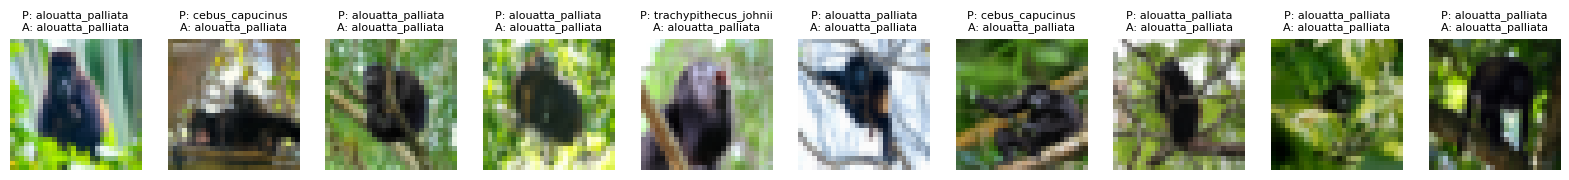

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation for the validation images
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load validation data
validation_path = '../data/monkey_data/monkey_testing/'
validation_data = datasets.ImageFolder(root=validation_path, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=False)

# Load labels from file and extract species names
labels_path = '../data/monkey_data/monkey_labels.txt'
with open(labels_path, 'r') as file:
    labels = file.readlines()
# Extract only the species name (second column)
species = [label.split(',')[1].strip() if len(label.split(',')) > 1 else '' for label in labels]

class MonkeyNet(nn.Module):
    def __init__(self):
        super(MonkeyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Initialize and load the model
model = MonkeyNet()
model.load_state_dict(torch.load('monkey_species_model.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Collect the images, predictions, and actual labels for display
images = []
predicted_labels = []
actual_labels = []

with torch.no_grad():
    for i, (data, target) in enumerate(validation_loader):
        if i >= 10:  # Limit to max 10 images
            break
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        images.append(data.cpu().squeeze())
        predicted_labels.append(species[pred.item()])
        actual_labels.append(species[target.item()])

# Display the images in a grid format
num_images = len(images)
fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

for i in range(num_images):
    img = images[i] / 2 + 0.5
    npimg = img.numpy()
    axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axs[i].set_title(f'P: {predicted_labels[i]}\nA: {actual_labels[i]}', fontsize=8)
    axs[i].axis('off')

plt.show()
